<a href="https://colab.research.google.com/github/arthurbabey/road66/blob/master/unet_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras-unet

In [2]:
from keras_unet.models import satellite_unet


Using TensorFlow backend.


In [3]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
model = satellite_unet(input_shape=(512, 512, 3))


In [0]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import sys
sys.path.append('/Users/arthurbabey/Documents/master2/ML/road66/scripts')


from skimage.transform import rotate
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg




# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def value_to_class(v, foreground_threshold=0.25): #modifier leur fonction en ajoutant f_t en param

    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def rotate_images(X, Y , degrees):
    """
    increase the number of data
    by adding rotations of the base data
    """

    X = np.array(X)
    Y = np.array(Y)
    rotimg = np.zeros(X.shape)
    rotgtimg = np.zeros(Y.shape)
    
    Xtemp = X
    Ytemp = Y
    
    #rotate all images by degree and add them to the data vector
    for degree in degrees:
        for i in range(len(Xtemp)):
            rotimg[i] = rotate(Xtemp[i], degree, resize=False, mode='reflect')
            rotgtimg[i] = rotate(Ytemp[i], degree, resize=False, mode='reflect')
        X = np.concatenate([X,rotimg])
        Y = np.concatenate([Y,rotgtimg])

    return X,Y

def resize_image(X, Y, size = 512):
  
    X = np.asarray(X)
    Y = np.asarray(Y)

    Xresize = np.asarray([resize(X[i], (size,size), mode = 'reflect') for i in range(X.shape[0])])
    Yresize = np.asarray([resize(Y[i], (size,size), mode = 'reflect') for i in range(X.shape[0])])

                        
    return Xresize, Yresize


    

def create_submission(y_pred, submission_filename, patch_size = 16, images_size = 608):
    n_patches = images_size // patch_size
    y_pred = np.reshape(y_pred, (-1, n_patches, n_patches))

    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i in range(y_pred.shape[0]):
            img = y_pred[i]
            for j in range(img.shape[0]):
                for k in range(img.shape[1]):
                    name = '{:03d}_{}_{},{}'.format(i + 1, j * patch_size, k * patch_size, int(img[j,k]))
                    f.write(name + '\n')

def balance_data(x_train, y_train):
    c0 = 0  # bgrd
    c1 = 0  # road
    for i in range(len(y_train)):
        if y_train[i][0] == 1:
            c0 = c0 + 1
        else:
            c1 = c1 + 1
    print('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))

    print('Balancing training data...')
    min_c = min(c0, c1)
    idx0 = [i for i, j in enumerate(y_train) if j[0] == 1]
    idx1 = [i for i, j in enumerate(y_train) if j[1] == 1]
    new_indices = idx0[0:min_c] + idx1[0:min_c]
    print(len(new_indices))
    print(x_train.shape)
    x_train = x_train[new_indices, :, :, :]
    y_train = y_train[new_indices]

    train_size = y_train.shape[0]

    c0 = 0
    c1 = 0
    for i in range(len(y_train)):
        if y_train[i][0] == 1:
            c0 = c0 + 1
        else:
            c1 = c1 + 1
    print('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))

    return x_train, y_train 


def img_crop(im, w, h, border = 0, step = 16):
    """
    Return the patches list of an image.
    """
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    if border != 0:
        im_r = np.pad(im[:,:,0], ((border, border), (border, border)), 'reflect')
        im_g = np.pad(im[:,:,1], ((border, border), (border, border)), 'reflect')
        im_b = np.pad(im[:,:,2], ((border, border), (border, border)), 'reflect')
        im = np.dstack((im_r, im_g, im_b))
    for i in range(0,imgheight,step):
        for j in range(0,imgwidth,step):
            if is_2d:
                im_patch = im[j:j+w+2*border, i:i+h+2*border]
            else:
                im_patch = im[j:j+w+2*border, i:i+h+2*border, :]
            list_patches.append(im_patch)
    return list_patches

In [8]:
# Loaded a set of images
root_dir = "drive/My Drive/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) # Use all images
print("Loading " + str(n) + " testing images")
imgs = [load_image(image_dir + files[i]) for i in range(100)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(100)]

Loading 100 testing images
Loading 100 groundtruth


In [0]:
imgs, gt_imgs = rotate_images(imgs, gt_imgs, [15, 30, 45, 60, 75, 90])

In [0]:
# 
# Preparation testing data to make a submission
# 

# 
# Ordering image
# 
root_testdir = "drive/My Drive/test_set_images"
test_names = os.listdir(root_testdir)


num_test = len(test_names)
order = [int(test_names[i].split("_")[1]) for i in range(num_test)]
index = np.argsort(order)

# Load image and reorder them
imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png") 
             for i in range(num_test)]
imgs_test = [imgs_test[i] for i in index]

In [0]:
Xr, Yr = resize_image(imgs, gt_imgs)

In [0]:
Yr = np.reshape(Yr, (700, 512, 512, 1))

In [0]:
x_train, x_val, y_train, y_val = train_test_split(Xr, Yr, 
                                                      test_size=0.25,  random_state=42)

In [0]:
model = satellite_unet(input_shape=(512, 512, 3))

In [0]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=3,
    data_gen_args = dict(
        horizontal_flip=True,
        vertical_flip=True,
    ))

In [0]:
from keras.callbacks import ModelCheckpoint


model_filename = 'UNET200plus.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [0]:
model.compile(loss='binary_crossentropy', #compile the model
              optimizer='adam',
              metrics=['binary_accuracy'])




history = model.fit_generator(
    train_gen,
    steps_per_epoch=700,
    epochs=35,   
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/35
700/700 [==============================] - 237s 338ms/step - loss: 0.1025 - binary_accuracy: 0.7473 - val_loss: 0.1181 - val_binary_accuracy: 0.7287

Epoch 00001: val_loss improved from inf to 0.11814, saving model to UNET200plus.h5
Epoch 2/35
700/700 [==============================] - 227s 325ms/step - loss: 0.0985 - binary_accuracy: 0.7477 - val_loss: 0.1163 - val_binary_accuracy: 0.7292

Epoch 00002: val_loss improved from 0.11814 to 0.11627, saving model to UNET200plus.h5
Epoch 3/35
700/700 [==============================] - 227s 325ms/step - loss: 0.0959 - binary_accuracy: 0.7479 - val_loss: 0.1226 - val_binary_accuracy: 0.7310

Epoch 00003: val_loss did not improve from 0.11627
Epoch 4/35
700/700 [==============================] - 227s 324ms/step - loss: 0.0939 - binary_accuracy: 0.7480 - val_loss: 0.1151 - val_binary_accuracy: 0.7308

Epoch 00004: val_loss improved from 0.11627 to 0.11512, saving model to UNET200plus.h5
Epoch 5/35
700/700 [============================

In [0]:
model.save_weights(filepath='goodgoodsave.h5')

In [0]:
model.load_weights('drive/My Drive/UNET200model.h5')


In [15]:
#model.load_weights('final_weight_50epoch.h5')
y_pred = model.predict(x_val, batch_size = 1, verbose = 1)

175/175 [==============================] - 11s 63ms/step


In [0]:
get_f1(y_val, y_pred)

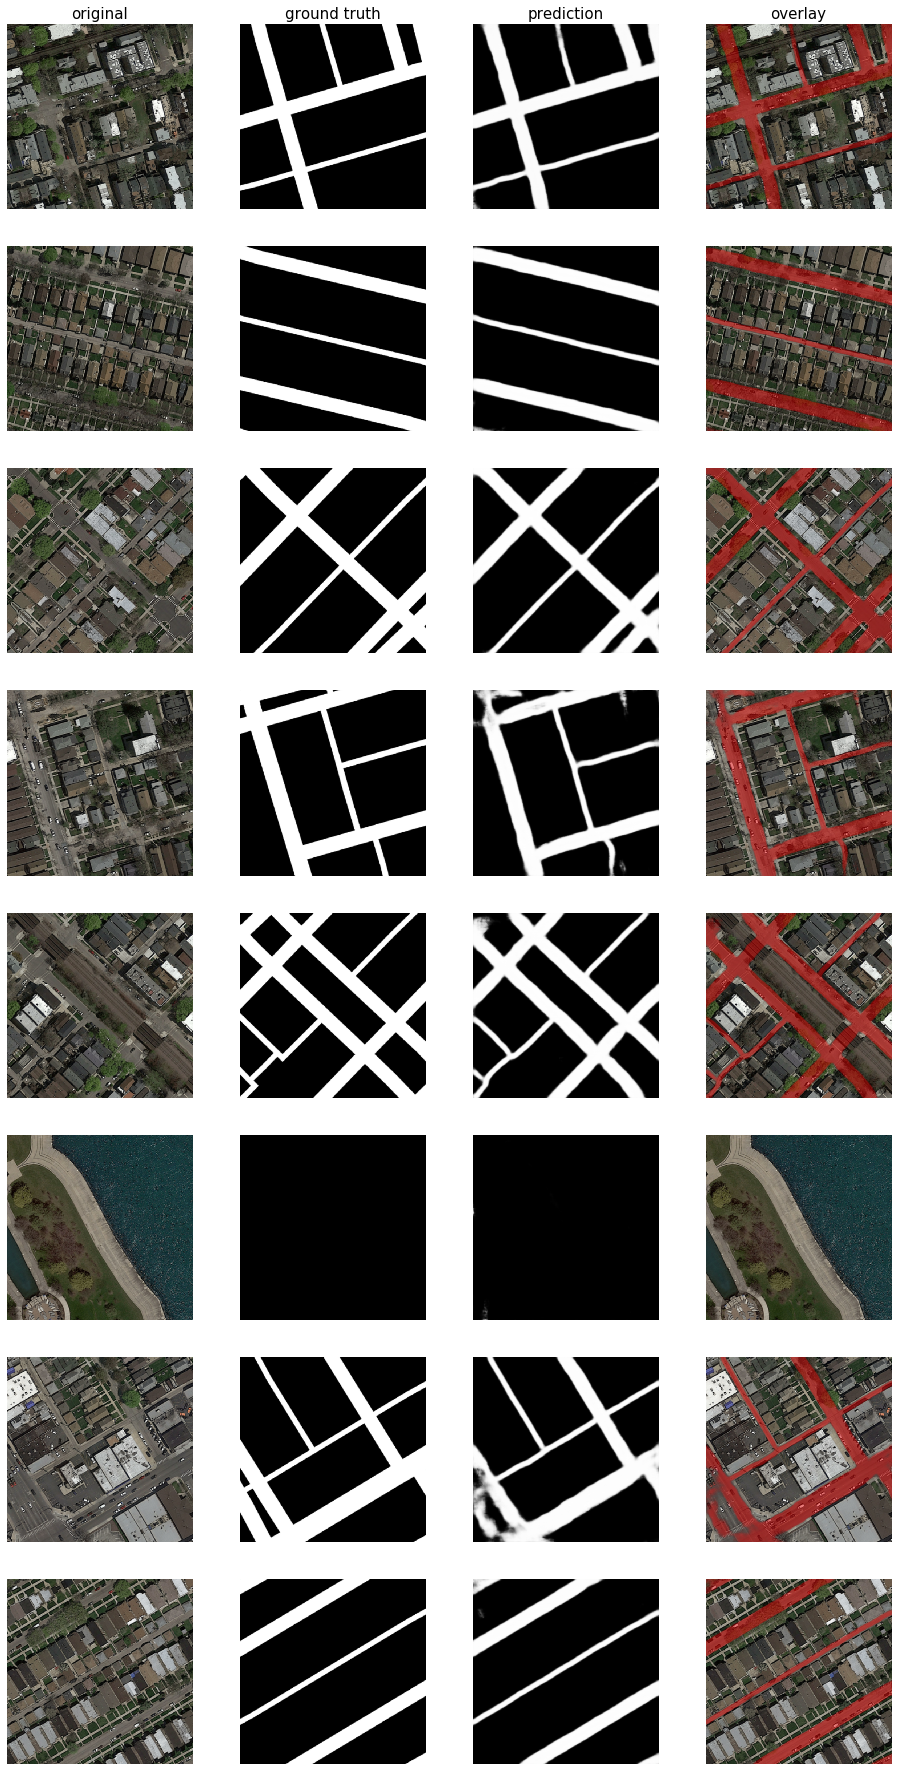

In [17]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=8)


In [50]:
X = np.asarray(imgs_test)

test_resize = np.asarray([resize(X[i], (512,512), mode = 'reflect') for i in range(X.shape[0])])
print(test_resize.shape)


(50, 512, 512, 3)


In [51]:
y_pred = model.predict(test_resize, batch_size=1, verbose = 1)
y_pred.shape, y_pred.sum()

50/50 [==============================] - 3s 58ms/step


((50, 512, 512, 1), 2818735.8)

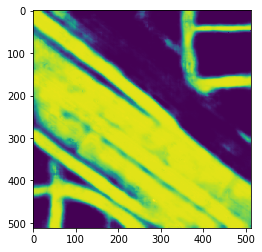

In [52]:
plt.imshow(np.reshape(y_pred[8], (512, 512)))

In [0]:
y_pred = np.asarray([resize(y_pred[i], (608,608), mode = 'reflect') for i in range(y_pred.shape[0])])

In [38]:
y_pred[y_pred < 0.5] = 0
y_pred[y_pred > 0.5] = 1

y_pred = np.asarray(y_pred)
y_pred.sum()

4174128.0

In [39]:
pred_patch = [img_crop(y_pred[i], 16, 16) for i in range(y_pred.shape[0])]


pred_patch = np.asarray([pred_patch[i][j] for i in range(len(pred_patch)) for j in range(len(pred_patch[i]))])

pred_patch = np.asarray([value_to_class(np.mean(pred_patch[i])) for i in range(pred_patch.shape[0])])

pred_patch.shape, pred_patch.sum()

((72200,), 20171)

In [0]:
create_submission(pred_patch, 'unetnet.csv')

In [0]:
from keras_unet.utils import get_patches

#patches_test = np.asarray([get_patches(img, 16, 16) for img in imgs_test])
patches_test = np.asarray([img_crop(img, 16, 16) for img in imgs_test])

print(patches_test.shape)

patches_test = np.asarray([patches_test[i][j] for i in range(patches_test.shape[0]) for j in range(patches_test.shape[1])])

patches_test.shape


(50, 1444, 16, 16, 3)


(72200, 16, 16, 3)

In [0]:
reste = patches_test[71680:72200, : , : , :]
patches_test = patches_test[0:71680, : , : , :]

reste.shape, patches_test.shape



((520, 16, 16, 3), (71680, 16, 16, 3))

In [0]:
from keras_unet.utils import reconstruct_from_patches

apa = reconstruct_from_patches(img_arr = patches_test, org_img_size = (512,512))

apa.shape

(70, 512, 512, 3)

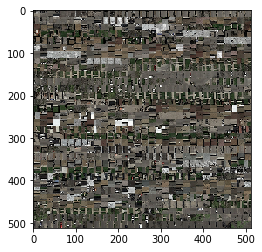

In [0]:
plt.imshow(apa[0])
plt.show()

In [0]:
y_pred = model.predict(apa, batch_size = 1, verbose = 1)
y_pred.shape, y_pred.sum()

70/70 [==============================] - 4s 55ms/step


((70, 512, 512, 1), 1606582.5)

In [0]:
print(y_pred.min())

y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

y_pred.sum()

0.0


1591551.0

In [0]:
pred_patch = np.asarray([get_patches(y_pred[i], 16, 16) for i in range(y_pred.shape[0])])
#pred_patch = np.asarray([img_crop(y_pred[i], 16, 16) for i in range(y_pred.shape[0])])

pred_patch = np.asarray([pred_patch[i][j] for i in range(pred_patch.shape[0]) for j in range(pred_patch.shape[1])])

pred_patch.shape, pred_patch.sum()


((71680, 16, 16, 1), 1591551.0)

In [0]:
pred_patch = np.asarray([value_to_class(np.mean(pred_patch[i])) for i in range(pred_patch.shape[0])])
pred_patch.shape, pred_patch.sum()


((71680,), 7895)

In [0]:
reste.shape

(520, 16, 16, 3)

In [0]:
for i in range(520):
  pred_patch = np.append(pred_patch, 0)

In [0]:
pred_patch.sum(), pred_patch.shape

(7895, (72200,))

In [0]:
create_submission(pred_patch, 'u_net_suba222.csv')

In [0]:
img1 = []
img2 = []
img3 = []
img4 = []


for img in imgs_test:
  img = img[0:512, 0:512, :]
  img1.append(img)

for img in imgs_test:
  img = img[96:608, 0:512, :]
  img2.append(img)

for img in imgs_test:
  img = img[96:608, 96:608, :]
  img3.append(img)

for img in imgs_test:
  img = img[0:512, 96:608, :]
  img4.append(img)

In [55]:
img.shape, np.asarray(img1).shape

((200, 512, 512, 3), (50, 512, 512, 3))

In [77]:
img_pred1 = model.predict(np.asarray(img1), batch_size = 1, verbose = 1)
img_pred2 = model.predict(np.asarray(img2), batch_size = 1, verbose = 1)
img_pred3 = model.predict(np.asarray(img3), batch_size = 1, verbose = 1)
img_pred4 = model.predict(np.asarray(img4), batch_size = 1, verbose = 1)


50/50 [==============================] - 3s 55ms/step


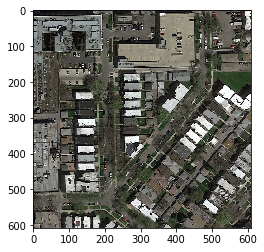

In [75]:
plt.imshow(imgs_test[3])#, plt.imshow(np.reshape(img_pred1[8], (512, 512)))

In [0]:
img_pred1[img_pred1 <= 0.5] = 0
img_pred1[img_pred1 > 0.5] = 1

img_pred2[img_pred2 <= 0.5] = 0
img_pred2[img_pred2 > 0.5] = 1

img_pred3[img_pred3 <= 0.5] = 0
img_pred3[img_pred3 > 0.5] = 1

img_pred4[img_pred4 <= 0.5] = 0
img_pred4[img_pred4 > 0.5] = 1

In [79]:
img1 = np.asarray(img1)
img2 = np.asarray(img2)
img3 = np.asarray(img3)
img4 = np.asarray(img4)



img1.shape

(50, 512, 512, 3)

In [0]:
img1 = np.asarray(img1)
img2 = np.asarray(img2)
img3 = np.asarray(img3)
img4 = np.asarray(img4)


m1 = np.concatenate((img1[0:96, : , :], img2[:, :, :]), axis=0)
m2 = np.concatenate((img4[0:96, : , :], img3[:, :, :]), axis = 0)




In [0]:
list_m1 = []
list_m2 = []

for i in range(50):
  m1 = np.concatenate((img_pred1[i, 0:96, :, :], img_pred2[i, :, :, :]), axis = 0)
  list_m1.append(m1)
  m2 = np.concatenate((img_pred1[i, 0:96, :, :], img_pred2[i, :, :, :]), axis = 0)
  list_m2.append(m2)




In [0]:
list_m1 = np.asarray(list_m1)
list_m2 = np.asarray(list_m2)

In [83]:
list_merge = []
for i in range(50):

  merge = np.concatenate((list_m1[i,:,:,:], list_m2[i, :, 416:512, :]), axis=1)
  list_merge.append(merge)

y_pred = np.asarray(list_merge)
y_pred.shape

(50, 608, 608, 1)

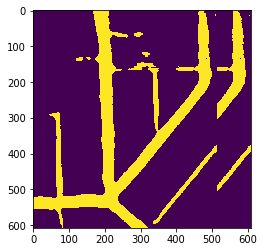

In [76]:
plt.imshow(np.reshape(y_pred[3], (608, 608)))

In [84]:

y_pred = np.asarray(y_pred)
y_pred.sum()

3807494.0

In [33]:
pred_patch = [img_crop(y_pred[i], 16, 16) for i in range(y_pred.shape[0])]


pred_patch = np.asarray([pred_patch[i][j] for i in range(len(pred_patch)) for j in range(len(pred_patch[i]))])

pred_patch = np.asarray([value_to_class(np.mean(pred_patch[i])) for i in range(pred_patch.shape[0])])

pred_patch.shape, pred_patch.sum()

((72200,), 18851)

In [0]:
create_submission(pred_patch, 'wayou.csv')